# Exploitation Zone

## Generate MultiModal embeddings

In [ ]:
import boto3
import os
from dotenv import load_dotenv

load_dotenv()
access_key_id = os.getenv("ACCESS_KEY_ID")
secret_access_key = os.getenv("SECRET_ACCESS_KEY")
minio_url = "http://" + os.getenv("S3_API_ENDPOINT")


minio_client = boto3.client(
    "s3",
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    endpoint_url=minio_url
)

new_bucket = "exploitation-zone-task2-images-text"
try:
    minio_client.create_bucket(Bucket=new_bucket)
except (minio_client.exceptions.BucketAlreadyExists, minio_client.exceptions.BucketAlreadyOwnedByYou):
    print(f"Bucket '{new_bucket}' already exists")

In [2]:
from abc import ABC, abstractmethod
from PIL import Image, ImageEnhance, ImageFilter
import os
import io
import chromadb
from chromadb.utils.data_loaders import ImageLoader
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
import torchaudio
import wav2clip

client = chromadb.HttpClient(host="localhost", port=8000)
paginator = minio_client.get_paginator('list_objects_v2')
exploitation_zone = "exploitation-zone-task2-images-text"
trusted_zone = "trusted-zone"
name_collection1 = "multimodal_collection_images"
name_collection2 = "multimodal_collection_text"
name_collection3 = "multimodal_collection_audios"

embedding_function = OpenCLIPEmbeddingFunction()
data_loader = ImageLoader()

try:
    client.delete_collection(name=name_collection1)
except Exception:
    pass

try:
    imatges_col = client.get_or_create_collection(
        name=name_collection1,
        embedding_function=embedding_function,
        data_loader=data_loader
    )
except Exception as e:
    print(f"Error accessing or creating collection: {e}")
    exit(1)

# FOR THE IMAGES NOW.
for page in paginator.paginate(Bucket=trusted_zone, Prefix="images/"):
    for obj in page.get("Contents", []):
        key = obj.get("Key", "")
        response = minio_client.get_object(Bucket=trusted_zone, Key=key)
        image_data = response['Body'].read()
        image = Image.open(io.BytesIO(image_data)).convert('RGB')

        temp_path = f"/tmp/{os.path.basename(key)}"
        with open(temp_path, "wb") as f:
            f.write(image_data)

        imatges_col.add(
            ids=[key],
            uris=[temp_path],
            metadatas=[{"bucket": trusted_zone, "key": key, "type": "image"}]
        )

        minio_client.copy_object(
            Bucket=exploitation_zone,
            CopySource={'Bucket': trusted_zone, 'Key': key},
            Key=key
        )
        
        
try:
    client.delete_collection(name=name_collection2)
except Exception:
    pass

try:
    text_col = client.get_or_create_collection(
        name=name_collection2,
        embedding_function=embedding_function,
    )
except Exception as e:
    print(f"Error accessing or creating collection: {e}")
    exit(1)
        
# FOR THE TEXT NOW.
for page in paginator.paginate(Bucket=trusted_zone, Prefix="text/"):
    for obj in page.get("Contents", []):
        key = obj.get("Key", "")
        response = minio_client.get_object(Bucket=trusted_zone, Key=key)
        document_content = response['Body'].read().decode('utf-8')
        
        text_col.add(
            ids=[key],
            documents=[document_content],
            metadatas=[{"bucket": trusted_zone, "key": key, "type": "text"}]
        )
        
        minio_client.copy_object(
            Bucket=exploitation_zone,
            CopySource={'Bucket': trusted_zone, 'Key': key},
            Key=key
        )
print("Col·lecció multimodal creada correctament!")
print("Nombre total d'elements:", len(text_col.get()["ids"]), len(imatges_col.get()["ids"]))
#print("returned keys:", list(result.keys()))

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Col·lecció multimodal creada correctament!
Nombre total d'elements: 0 100


In [4]:
from IPython.display import display
from PIL import Image
import io

def query_multimodal(query_text, text_col, imatges_col, minio_client, top_k=3):
    """
    Donat un text, busca les imatges i textos més similars
    usant dues col·leccions sincronitzades amb CLIP.
    """

    print(f"\nQuery: '{query_text}'")
    print("=" * 90)

    emb = imatges_col._embedding_function([query_text])[0]

    res_texts = text_col.query(query_embeddings=[emb], n_results=top_k, include=["documents", "distances"])
    res_imgs  = imatges_col.query(query_embeddings=[emb], n_results=top_k, include=["metadatas", "distances"])

    # --- TEXTS similars ---
    print("\nTextos similars:")
    for i, (doc, dist) in enumerate(zip(res_texts["documents"][0], res_texts["distances"][0])):
        preview = doc.strip().replace("\n", " ")
        print(f"{i+1}. (dist={dist:.4f}) {preview[:200]}...")

    # --- IMATGES similars ---
    print("\nImatges similars:")
    for i, (meta, dist) in enumerate(zip(res_imgs["metadatas"][0], res_imgs["distances"][0])):
        bucket = meta.get("bucket")
        key = meta.get("key")
        print(f"{i+1}. (dist={dist:.4f}) {key}")

        try:
            response = minio_client.get_object(Bucket=bucket, Key=key)
            image_data = response["Body"].read()
            img = Image.open(io.BytesIO(image_data))
            display(img)
        except Exception as e:
            print(f"No s'ha pogut mostrar la imatge: {e}")



Query: 'CAT'

Textos similars:

Imatges similars:
1. (dist=0.7689) images/ISIC_0034196.png


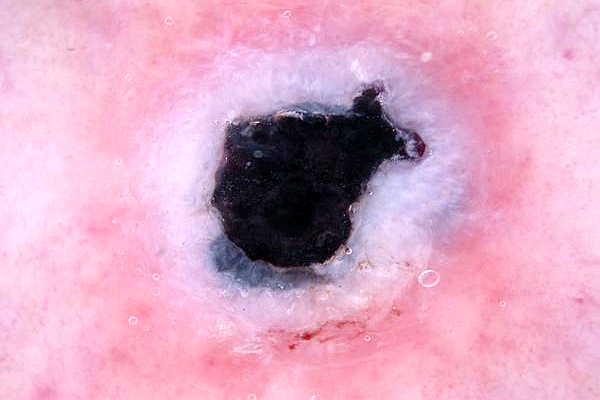

2. (dist=0.7725) images/ISIC_0025202.png


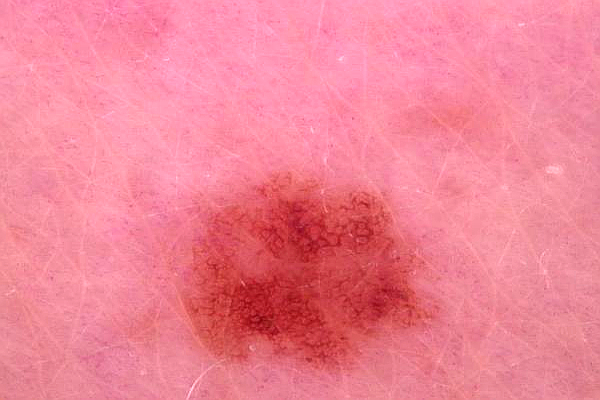

3. (dist=0.7726) images/ISIC_0030197.png


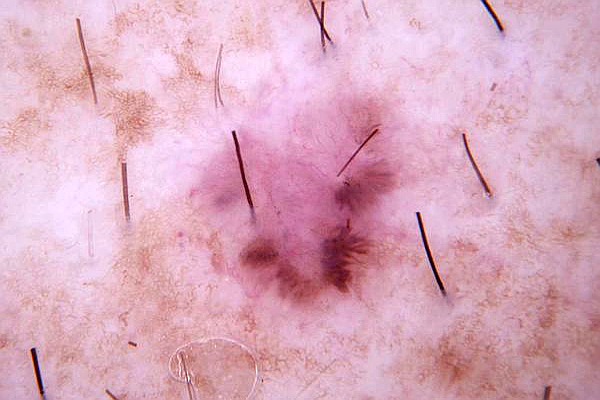

In [7]:
query_multimodal(
    query_text="CAT",
    text_col=text_col,
    imatges_col=imatges_col,
    minio_client=minio_client,
    top_k=3
)


### Load ImageBind model
To generate multimodal embeddings we will use Meta's ImageBind model, which supports audio, text, images and more. It is recommended to have 16GB or more of RAM memory so the jupyter notebooks does not crash when trying to load the model.

To install imagebind, it is needed to:
```bash
git clone https://github.com/facebookresearch/ImageBind.git
cd ImageBind
pip install .
```

Then, we can load the model as:

In [1]:
from imagebind import data
import torch
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)


/home/jowy/ADSDB/.venv/lib/python3.12/site-packages/imagebind/data.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/jowy/ADSDB/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

After downloading the model, we can generate embeddings as:

In [9]:
# Load data

import os

text_list=["skin cancer", "melanoma", "disease", "treatment of skin", "cancerous cells"]
image_paths=[]


for i, file in enumerate(os.listdir("../../output/dataset1/")):
    print(file)
    image_paths.append("../../output/dataset1/" + file)
    if (i > 10):
        break

inputs = {
    ModalityType.TEXT: data.load_and_transform_text(text_list, device),
    ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device),
    #ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device),
}

with torch.no_grad():
    embeddings = model(inputs)

print(
    "Vision x Text: ",
    torch.softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.TEXT].T, dim=-1),
)
#print(
#    "Audio x Text: ",
#    torch.softmax(embeddings[ModalityType.AUDIO] @ embeddings[ModalityType.TEXT].T, dim=-1),
#)
#print(
#    "Vision x Audio: ",
#    torch.softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.AUDIO].T, dim=-1),
#)



ISIC_0026077.jpg
ISIC_0033505.jpg
ISIC_0033053.jpg
ISIC_0028025.jpg
ISIC_0033055.jpg
ISIC_0033103.jpg
ISIC_0029024.jpg
ISIC_0029263.jpg
ISIC_0034129.jpg
ISIC_0034128.jpg
ISIC_0031981.jpg
ISIC_0028280.jpg
Vision x Text:  tensor([[3.8641e-01, 3.5846e-01, 2.8468e-02, 2.1199e-04, 2.2645e-01],
        [5.1542e-01, 4.8429e-01, 1.0336e-05, 8.9915e-05, 1.9435e-04],
        [6.4042e-01, 3.5880e-01, 9.8710e-06, 2.0881e-05, 7.5289e-04],
        [8.2112e-01, 1.7791e-01, 5.7085e-05, 6.6415e-05, 8.4862e-04],
        [6.7139e-01, 3.2633e-01, 1.9876e-05, 5.6236e-05, 2.2118e-03],
        [2.3535e-01, 7.6418e-01, 1.2122e-05, 2.2042e-05, 4.3175e-04],
        [7.7131e-01, 2.2822e-01, 5.0370e-05, 3.6447e-04, 5.6506e-05],
        [5.8127e-01, 2.3806e-01, 8.6084e-02, 1.5543e-02, 7.9042e-02],
        [3.1205e-01, 6.7687e-01, 4.4543e-04, 4.1093e-04, 1.0222e-02],
        [9.1387e-02, 9.0800e-01, 7.6577e-06, 5.1658e-07, 5.9999e-04],
        [1.0018e-01, 8.7303e-01, 1.4302e-02, 4.0766e-04, 1.2079e-02],
        [3